In [39]:
from sklearn.datasets import make_classification
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

In [40]:
# simulate data for classification 
X, y = make_classification(n_samples = 500,
                                       n_features = 5,
                                       n_informative = 2,
                                       n_redundant = 2,
                                       n_classes = 2,
                                       random_state = 888
                                       )

In [41]:
# check feature matrix
print("Feature Matrix: ");
print(pd.DataFrame(X, columns=["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"]).head())

Feature Matrix: 
   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5
0  -0.980745   1.397817   0.097420   1.816219   2.255405
1   0.272650   0.952904  -0.120022   1.258919   1.577617
2  -0.280564   1.366616   0.605139   1.718828   2.095423
3   0.762558   0.585822   0.218204   0.741397   0.907096
4  -0.173253   0.050620  -1.965157   0.285270   0.504989


In [42]:
# check labels 
print("class_label: ");
print(pd.DataFrame(y, columns=["class_label"]).tail())

class_label: 
     class_label
495            0
496            0
497            1
498            0
499            1


In [43]:
# obtain a dataframe
df = pd.DataFrame(X, columns=["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"])
class_label = pd.DataFrame(y, columns=["class_label"])
df['class_label'] = class_label
df.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,class_label
0,-0.980745,1.397817,0.097420,1.816219,2.255405,1
1,0.272650,0.952904,-0.120022,1.258919,1.577617,1
2,-0.280564,1.366616,0.605139,1.718828,2.095423,1
3,0.762558,0.585822,0.218204,0.741397,0.907096,1
4,-0.173253,0.050620,-1.965157,0.285270,0.504989,1


In [44]:
# check how many cases belong to each class 
df['class_label'].value_counts()

1    250
0    250
Name: class_label, dtype: int64

In [45]:
# divide the data into training and test subsets, separate the label 
from sklearn.model_selection import train_test_split
y = df[['class_label']]
X = df.drop(['class_label'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # check the shape 

(350, 5) (350, 1) (150, 5) (150, 1)


In [46]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [47]:
# proceed with grid search to find optimal parameters for the model 
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

estimator = xgb.XGBClassifier()
parameters = {'colsample_bytree': [0.1, 0.3, 0.5],
                'n_estimators': [100, 200, 10],
                'max_depth': [3, 15],
                'learning_rate': [0.1, 0.01, 0.05],}
gs = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='accuracy', cv=10)
tune_results = gs.fit(X_train, y_train)

#Get best hyperparameter results
gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'n_estimators': 200}

In [48]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [49]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# tuned model 
tuned_xgb = xgb.XGBClassifier(learning_rate = 0.05, colsample_bytree = 0.5, n_estimators = 200, max_depth = 15)
model = tuned_xgb.fit(X_train, y_train)

# make predictions on the test set
y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

acc_score = metrics.accuracy_score(y_test.values, y_preds)
auc_score = metrics.roc_auc_score(y_test, y_probs)


In [50]:
# accuracy 
acc_score

0.9266666666666666

In [51]:
# AUC score 
auc_score

0.9802193850026973

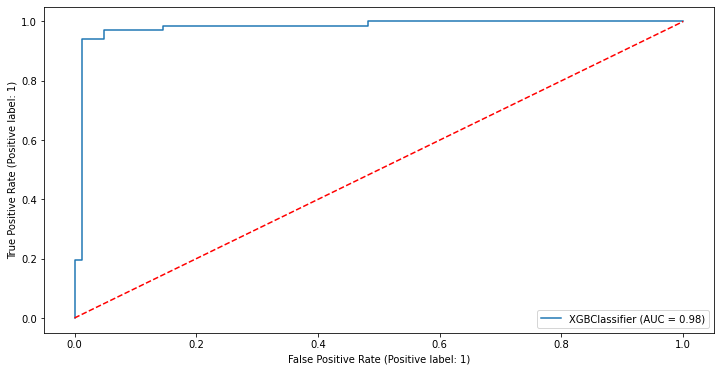

In [52]:
# AUC plot 
metrics.plot_roc_curve(gs.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

**Trying CV on real data**

Below I try CV on a real dataset instead of a simulation. I chose a customer churn dataset which I obtained from Kaggle: https://www.kaggle.com/mathchi/churn-for-bank-customers

This is a labeled dataset that containes detailed information about bank customers. The label "Exited" is binary and shows whether each customer left the bank (1) or stayed (0). 

In [53]:
# load the data
file = 'https://raw.githubusercontent.com/vartanim/Numerical-Introductory-Seminar/main/churn.csv'
df = pd.read_csv(file)
df = df.drop(['RowNumber'], axis=1)
df = df.drop(['Gender'], axis=1)

# call the first 5 rows
df.head()

,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [54]:
# check datat types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [55]:
# I think surnames and geographic location can be considered as categorical variables, therefore I change their data types to categories. 
df['Surname'] = df['Surname'].astype('category')
df['Geography'] = df['Geography'].astype('category')

In [56]:
# classification algorithm i will use is not compatible with categorical features, therefore I used weight of evidense encoding for them
# I created a custom function woe() which calculates weight of evidense for each value in chosen columns and assighs it to the dataframe by creating a new column 
def woe(df, a):
    woe_df = df.groupby(a)['Exited'].mean()
    woe_df = pd.DataFrame(woe_df)
    woe_df['Not_exited'] = 1-woe_df['Exited']
    woe_df['WoE_' + a] = np.log(woe_df['Exited']/woe_df['Not_exited'])  # add new column to the dataframe 
    df.loc[:, 'WoE_' + a] = df[a].map(woe_df['WoE_' + a]) # add obtained WoEs to the dataframe 
    return df

In [57]:
#Apply WoE encoding to the data
cols = df.select_dtypes(include=['category']).columns.copy() # choose only categorical variables
for col_name in cols:
    df_cc = woe(df, col_name)

df = df.drop(cols, axis=1)

df.head() # check the result

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,WoE_Surname,WoE_Geography
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,inf,-1.646757
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,-2.014903,-1.608954
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,-1.098612,-1.646757
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,-1.299283,-1.646757
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,-2.197225,-1.608954


In [58]:
# get rid of infinity values which appeared after WOE encoding
df.replace([np.inf, -np.inf], 0, inplace = True)

In [59]:
# call first 5 rows to check how the above operations worked out 
df.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,WoE_Surname,WoE_Geography
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0.000000,-1.646757
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,-2.014903,-1.608954
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,-1.098612,-1.646757
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,-1.299283,-1.646757
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,-2.197225,-1.608954


In [60]:
# target variable is a binary label => change data type to boolean
df['Exited'] = df['Exited'].astype('bool')

In [61]:
df['Exited'].value_counts() # check how many observations belong to each class. The data is imbalanced: less True than False values

False    7963
True     2037
Name: Exited, dtype: int64

In [62]:
df.info() # check data types again; after WOE encoding, column "WoE_Geography" remained as a categorical feature. I changed it to float. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerId       10000 non-null  int64   
 1   CreditScore      10000 non-null  int64   
 2   Age              10000 non-null  int64   
 3   Tenure           10000 non-null  int64   
 4   Balance          10000 non-null  float64 
 5   NumOfProducts    10000 non-null  int64   
 6   HasCrCard        10000 non-null  int64   
 7   IsActiveMember   10000 non-null  int64   
 8   EstimatedSalary  10000 non-null  float64 
 9   Exited           10000 non-null  bool    
 10  WoE_Surname      10000 non-null  float64 
 11  WoE_Geography    10000 non-null  category
dtypes: bool(1), category(1), float64(3), int64(7)
memory usage: 801.0 KB


In [63]:
# change WoE_Geography to float data type 
df['WoE_Geography'] = df['WoE_Geography'].astype('float')

In [64]:
#df.to_csv('prepped_df.csv') #save as csv.
#from google.colab import files
#files.download("prepped_df.csv")

In [67]:
# divide the data into training and test subsets, separate the label 
from sklearn.model_selection import train_test_split
y = df[['Exited']]
X = df.drop(['Exited'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # check the shape 

(7000, 11) (7000, 1) (3000, 11) (3000, 1)


In [68]:
# proceed with grid search to find optimal parameters for the model.
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

n = 10
estimator = xgb.XGBClassifier()
parameters = {'colsample_bytree': [0.1, 0.3, 0.5],
                'n_estimators': [100, 300, 10],
                'max_depth': [3, 15],
                'learning_rate': [0.1, 0.01, 0.05],}
gs = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='accuracy', cv=n)
tune_results = gs.fit(X_train, y_train.values.ravel())

#Get best hyperparameter results
gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 300}

In [69]:
# plug the obtained parameters in the model 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# tuned model 
tuned_xgb = xgb.XGBClassifier(learning_rate = 0.05, colsample_bytree = 0.5, n_estimators = 300, max_depth = 3)
model = tuned_xgb.fit(X_train, y_train.values.ravel())

# make predictions on the test set
y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

acc_score = metrics.accuracy_score(y_test.values, y_preds) # accuracy score to check model performance
auc_score = metrics.roc_auc_score(y_test, y_probs) # area under the curve to check model performance 
# botj measures will be described in the final report 

In [70]:
acc_score # accuracy: the closer to 1, the better

0.8726666666666667

In [71]:
auc_score # AUC: the closer to 1, the better

0.8785955575128086

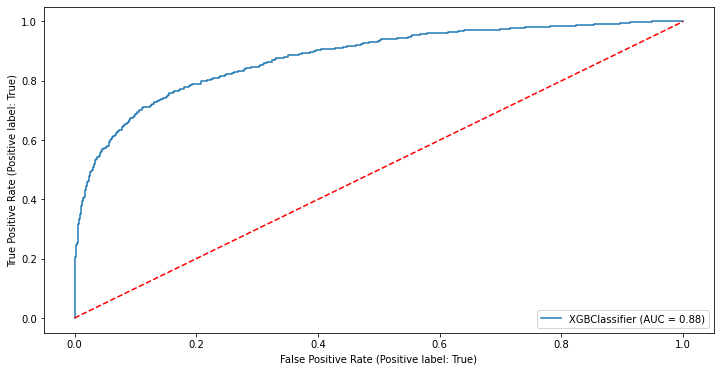

In [72]:
# graphical representation of model merformance: area under the ROC curve. 
import matplotlib.pyplot as plt 
metrics.plot_roc_curve(gs.best_estimator_, X_test, y_test) 
plt.plot([0, 1], [0, 1], "r--"); # set a random benchmark (red dotted line)